# Simulating the formation of myosin clusters
In this notebook, I constructed a simple toy model to simulate the formation of myosin clusters. 

There are a series of random grids where myosin could bind (indices `0` to `numGrid`)

Each grid has its own F-actin density.

In each iteration, a single myosin lands on a random grid based on a probability distribution, which is proportional to a) the F-actin density, and/or b) existing number of myosin on that grid. This simulates the accretion process.

Then, randomly draw vertices that undergo contraction, find their neighbors, and decide which neighbors to merge with. This simulates the coalescence process.

Repeat the process until all myosin have landed to a grid, or if there are no more grids to bind.

### To Do
-  Capping myosin capacity doesn't work well?

In [3]:
# Import packages
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from random import choices
import seaborn as sns
import random
from scipy.spatial import Delaunay
#import networkx as nx

## 1D myosin binding simulation

[2 3 3 1 1 3 3 3 1 1 1 3 3 2 3 3 2 4 3 2 4 3 2 2 3 3 1 5 3 3 3 2 3 4 2 2 4
 3 2 2 3 2 3 4 2 2 2 4 2 1 2 2 4 1 3 3 3 4 2 3 3 2 2 3 3 2 2 1 1 4 1 4 4 2
 1 1 0 4 4 1 2 2 2 2 4 3 2 2 4 4 2 2 4 3 4 2 3 3 3 2 3 3 2 2 2 3 3 2 1 3 4
 2 4 2 3 4 3 3 2 2 4 1 2 2 5 1 2 4 4 3 1 4 4 4 4 3 1 2 2 3 0 5 3 3 3 0 2 1
 2 2 1 2 0 2 4 3 2 2 2 2 3 4 3 2 1 2 5 3 2 2 2 3 3 2 2 1 1 2 2 3 4 3 3 2 2
 3 3 2 3 3 3 4 3 3 3 3 3 2 2 3 3 2 3 2 2 4 3 2 3 4 4 3 2 3 3 2 3 1 2 2 1 2
 3 2 2 2 1 3 2 3 2 3 3 2 3 1 5 1 3 2 4 1 2 1 2 1 1 5 2 2 1 3 3 3 3 4 3 1 3
 3 2 1 2 3 2 2 4 2 2 4 4 2 1 1 3 2 2 3 3 3 2 4 3 1 4 5 0 3 2 2 3 4 3 2 4 3
 1 1 2 3 4 2 3 3 1 3 3 5 2 1 5 2 2 3 3 3 2 3 3 2 2 3 3 2 3 2 0 0 3 1 3 2 2
 3 4 2 2 3 4 1 2 2 2 3 3 2 3 3 2 1 4 2 3 2 3 4 3 3 3 3 4 2 3 2 3 2 3 2 3 3
 2 5 2 2 2 3 2 3 4 3 2 3 1 2 2 1 2 3 3 2 1 2 2 3 2 1 3 1 1 3 2 2 3 2 2 1 2
 2 4 0 2 2 2 3 1 3 3 5 1 1 3 3 1 2 3 3 2 4 1 4 3 3 4 3 1 4 3 4 4 3 3 3 3 3
 3 0 2 3 2 2 3 2 3 2 2 5 5 2 4 2 0 3 3 2 2 2 1 2 2 2 3 4 1 3 1 4 4 3 4 2 1
 2 4 3 2 2 3 5 2 1 2 1 2 

(array([ 25.,   0., 133.,   0., 336.,   0., 352.,   0., 126.,  28.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <BarContainer object of 10 artists>)

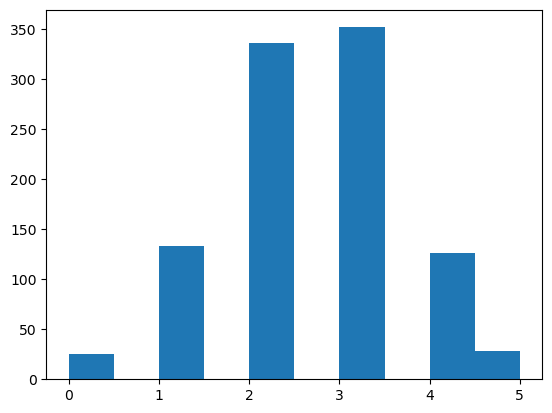

In [12]:
#def merger():
from numpy.random import default_rng
rng = default_rng()
myosinNum = rng.normal(loc=3, scale=1, size = 1000).astype(int)
#print(myosinNum)

plt.hist(myosinNum)#, bins=[0,1,2,3,4,5,6])

In [83]:
# Define function that generates the underlying actin distribution
from numpy.random import default_rng
def GenActinThick(method, numGrid, *keys):
    rng = default_rng()
    if method == 'lognormal':
        ## Passed argument should be mu and sigma
        (mu, sigma) = keys
        ActinThick = rng.lognormal(mu, sigma, (numGrid))
    elif method == 'normal':
        ## Passed argument should be loc and scale
        (loc, scale) = keys
        ActinThick = rng.normal(loc, scale, (numGrid))
    elif method == 'uniform':
        ## Passed argument should be low and high
        (low, high) = keys
        ActinThick = rng.uniform(low, high, (numGrid))
    elif method == 'poisson':
        ## Passed argument should be lambda
        lam = keys
        ActinThick = rng.poisson(lam, (numGrid))
    else:
        raise ValueError('Method not supported!')
    return ActinThick

# Define function that runs simulation based on weights that are defined
def runSimulation(numMyosin, numGrid, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge):
    ### Initialize myosin cluster size
    rng = default_rng()
    MyosinNum = rng.normal(loc=3, scale=1, size = numGrid).astype(int) 
        
    # Define probability weights and draw random grid number that myosin lands
    for ii in range(numMyosin):
        index = np.arange(0, numGrid)
        actinBias = ActinThick * actinBiasVal
        myosinBias = MyosinNum * myosinBiasVal
        weights = np.ones((numGrid)) * (1+actinBias) * (1+myosinBias)
        #weights = weights * np.exp(-MyosinNum/ActinThick/myoCap)
        #weights = np.array(weights/sum(weights)) * np.exp(-np.maximum(0, np.array(MyosinNum)-myoCap))     ## Binding probability exponentially decays if exceeds binding capacity
        #weights[np.array(MyosinNum)>=myoCap] = 0   ###!!!!!!! Anything site that exceed capacity can't bind
        if len(np.nonzero(weights)[0]) == 0:    ### Terminate if no more available sites
            break
        else:
            landing = choices(index, weights)
            MyosinNum[landing] = MyosinNum[landing] + 1
            
        
        #numMerger = numGrid*activity
        #if numMerger>0 and numMerger<1:
        #    numMerger = np.random.random_sample()<numMerger
        
        #if numMerger > 0.0:
        #    numMerger = round(numMerger)
        #    merger_id = np.random.randint(0, numGrid-1, (numMerger))
        #    for edges in merger_id:
        #        MyosinNum[edges]=MyosinNum[edges]+MyosinNum[edges+1]
        #        MyosinNum[edges+1]=-1
        #        ActinThick[edges]=ActinThick[edges]+ActinThick[edges+1]
        #        ActinThick[edges+1]=-1
        #    MyosinNum = MyosinNum[MyosinNum!=-1]
        #    #print(MyosinNum.shape)
        #    ActinThick = ActinThick[ActinThick!=-1]
        #    #print(ActinThick.shape)
        #    numGrid -= numMerger

        diff = np.abs(MyosinNum[1:] - MyosinNum[0:-1])
        merge_cand = np.where(diff>merge_thresh)[0]
        for jj in merge_cand:
            if np.random.rand()<Pmerge:
                (mergeId, tomerge) = (jj, jj+1)
                if MyosinNum[jj]<MyosinNum[jj+1]:
                    (mergeId, tomerge) = (jj+1, jj)
                MyosinNum[mergeId]=MyosinNum[mergeId]+MyosinNum[tomerge]
                MyosinNum[tomerge]=0
                ActinThick[jj]=ActinThick[jj]+ActinThick[tomerge]
                ActinThick[tomerge]=1

        #if dis_rate > 0.0:
        #    numDisassemble = math.floor(dis_rate)
        #    if (dis_rate-numDisassemble) > np.random.random_sample():
        #        numDisassemble += 1
        #    dis_prob = np.array(MyosinNum) * np.exp(-np.array(MyosinNum))
        #    count = 0
        #    while count < numDisassemble:
        #        dis_id = choices(index, dis_prob)
        #        MyosinNum[dis_id] = 0
        #        count += 1
                
        
    #print(ii)
    return MyosinNum

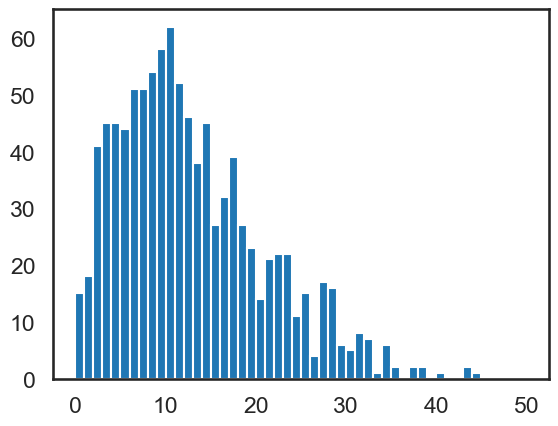

In [84]:
numMyosin = 10000
numGrid = 1000
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
#myoCap = 30
actinBiasVal = 0
myosinBiasVal = 3
merge_thresh = 100000000
Pmerge = 0.
res = runSimulation(numMyosin, numGrid, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
plt.hist(res[res>=0], bins = np.linspace(0, 50, 51))
plt.show()

In [96]:
# Simulation: no biases, random binding
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
actinBiasVal = 0
myosinBiasVal = 0
merge_thresh = 100000000
Pmerge = 0.
numMyosin = 10000
numGrid = 1000
numSim = 10

allRes = np.zeros((numSim, numGrid))
for ii in range(numSim):
    res = runSimulation(numMyosin, numGrid, ActinThick, actinBiasVal, myosinBiasVal, merge_thresh, Pmerge)
    allRes[ii, :] = res

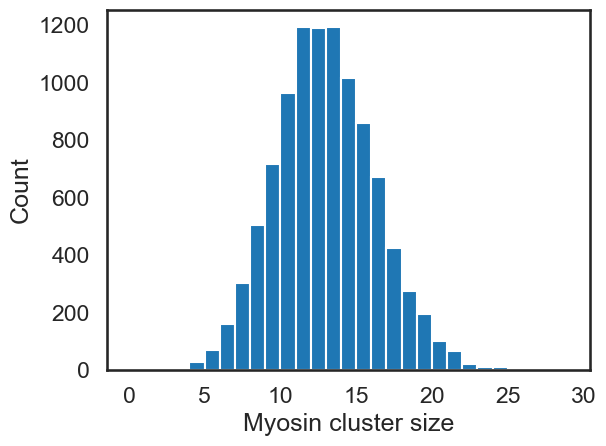

In [97]:
sns.set_style("white")
sns.set_context("talk")
plt.hist(np.reshape(allRes, (numSim*numGrid, 1)), bins = np.arange(30))
plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("myosinBinding_histogram_acBias_0_myoBias_0.png", dpi = 300)

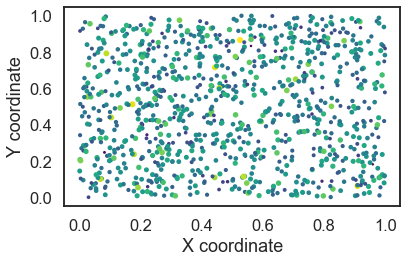

In [47]:
sns.set_style("white")
sns.set_context("talk")
plt.scatter(coordinates[:,0], coordinates[:,1], s = res, c = res, cmap = "viridis")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.tight_layout()
plt.savefig("myosinBinding_map_acBias_0_myoBias_0.png", dpi = 300)

## Bias towards F-actin

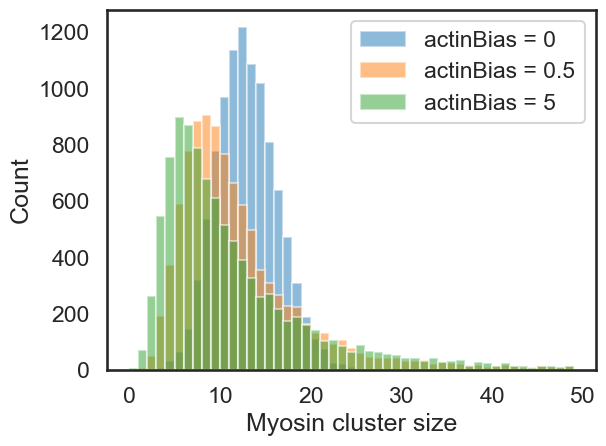

In [94]:
## Run simulation
# Simulation parameters
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = [0, .5, 5]
myosinBiasVal = 0
merge_thresh = 100000000
Pmerge = 0.
numMyosin = 10000
numGrid = 1000
numSim = 10

sns.set_style("white")
sns.set_context("talk")
plt.figure()
#plt.rcParams['font.size'] = '16'
for ii in range(len(actinBiasVal)):
    numSim = 10
    countRes = np.zeros((numSim, 80))
    allRes = np.zeros((numSim, numGrid))
    for jj in range(numSim):
        # Run simulations
        res = runSimulation(numMyosin, numGrid, ActinThick, actinBiasVal[ii], myosinBiasVal, merge_thresh, Pmerge)
        allRes[jj, :] = res   # Number of myosin particles
    plt.hist(np.reshape(allRes, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = "actinBias = " + str(actinBiasVal[ii]))

plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("myosinBinding_histogramComp_myoBias_0_mu_1_sigma_1_actinBiasComp.png", dpi = 300)

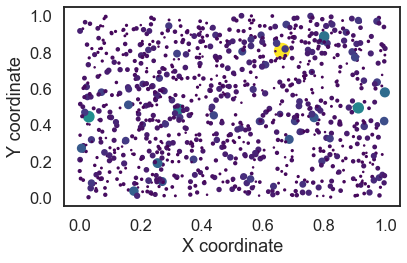

In [61]:
sns.set_style("white")
sns.set_context("talk")
plt.scatter(coordinates[:,0], coordinates[:,1], s = res, c = res, cmap = "viridis")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.tight_layout()
plt.savefig("myosinBinding_map_acBias_5_myoBias_0_mu_1_sigma_1.png", dpi = 300)

## Dependence on F-actin distribution

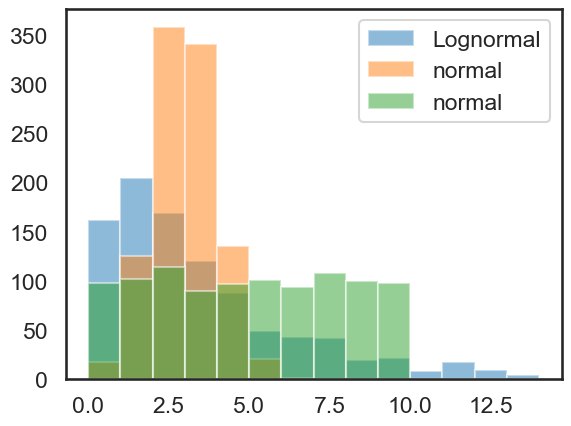

In [89]:
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(GenActinThick('lognormal', numGrid, 1, 1), bins = np.arange(15), alpha = 0.5, label = 'Lognormal')
plt.hist(GenActinThick('normal', numGrid, 3, 1), bins = np.arange(15), alpha = 0.5, label = 'normal')
plt.hist(GenActinThick('uniform', numGrid, 0, 10), bins = np.arange(15), alpha = 0.5, label = 'normal')
plt.legend()
#plt.savefig("actin_dist_comp.png", dpi = 300)

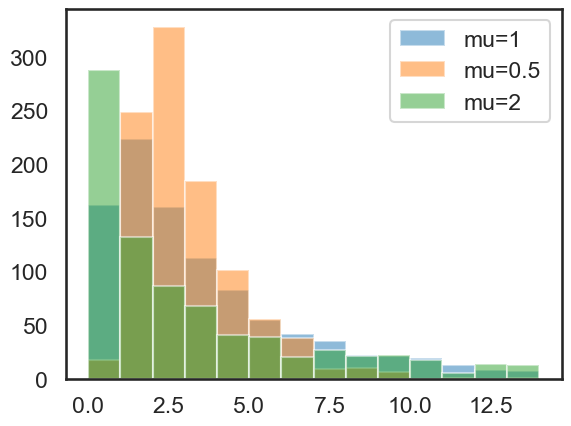

In [92]:
sns.set_style("white")
sns.set_context("talk")
plt.figure()
plt.hist(GenActinThick('lognormal', numGrid, 1, 1), bins = np.arange(15), alpha = 0.5, label = 'mu=1')
plt.hist(GenActinThick('lognormal', numGrid, 1, 0.5), bins = np.arange(15), alpha = 0.5, label = 'mu=0.5')
plt.hist(GenActinThick('lognormal', numGrid, 1, 2), bins = np.arange(15), alpha = 0.5, label = 'mu=2')
plt.legend()
#plt.savefig("actin_dist_comp.png", dpi = 300)

## Myosin bias

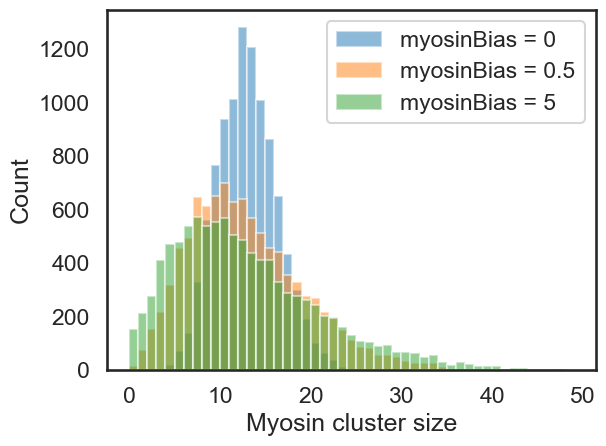

In [95]:
## Run simulation
# Simulation parameters
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
#myoCap = 1000   # Cap the number of myosin per site
actinBiasVal = 0
myosinBiasVal = [0, .5, 5]
merge_thresh = 100000000
Pmerge = 0.
numMyosin = 10000
numGrid = 1000
numSim = 10

sns.set_style("white")
sns.set_context("talk")
plt.figure()
#plt.rcParams['font.size'] = '16'
for ii in range(len(myosinBiasVal)):
    countRes = np.zeros((numSim, 80))
    allRes = np.zeros((numSim, numGrid))
    for jj in range(numSim):
        # Run simulations
        res = runSimulation(numMyosin, numGrid, ActinThick, actinBiasVal, myosinBiasVal[ii], merge_thresh, Pmerge)
        allRes[jj, :] = res   # Number of myosin particles
    plt.hist(np.reshape(allRes, (numSim*numGrid, 1)), bins = np.arange(50), alpha = 0.5, label = "myosinBias = " + str(myosinBiasVal[ii]))

plt.xlabel("Myosin cluster size")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("myosinBinding_histogramComp_acBias_0_mu_1_sigma_1_myoBiasComp.png", dpi = 300)

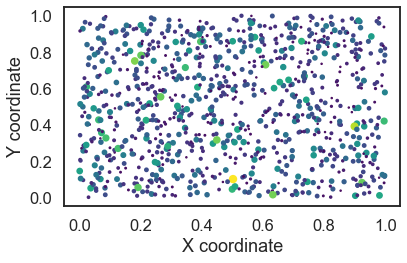

In [66]:
res = runSimulation(numMyosin, mu, sigma, myoCap, actinBias, 0.5)
sns.set_style("white")
sns.set_context("talk")
plt.scatter(coordinates[:,0], coordinates[:,1], s = res, c = res, cmap = "viridis")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.tight_layout()
plt.savefig("myosinBinding_map_acBias_0_myoBias_0.5_mu_1_sigma_1.png", dpi = 300)

## Actomyosin correlation

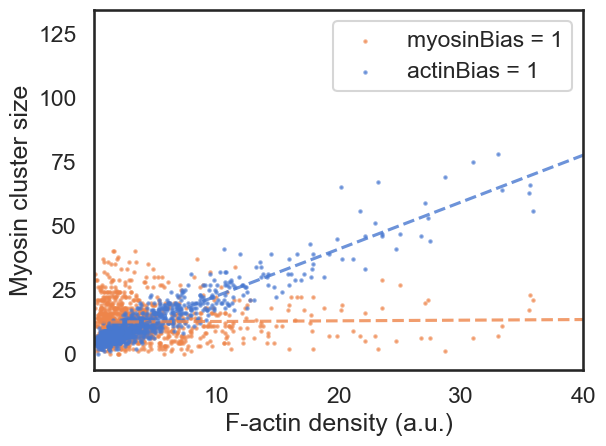

In [113]:
mu = 1
sigma = 1
ActinThick = GenActinThick('lognormal', numGrid, mu, sigma)
#myoCap = 1000   # Cap the number of myosin per site
merge_thresh = 100000000
Pmerge = 0.
numMyosin = 10000
numGrid = 1000

# Run simulations
resAcBias = runSimulation(numMyosin, numGrid, ActinThick, 1, 0, merge_thresh, Pmerge)
resMyoBias = runSimulation(numMyosin, numGrid, ActinThick, 0, 1, merge_thresh, Pmerge)

acFit = st.linregress(ActinThick, resAcBias)
myoFit = st.linregress(ActinThick, resMyoBias)

sns.set_style("white")
sns.set_context("talk")
co = sns.color_palette('muted')
xt = np.arange(ActinThick.max())
plt.figure()
plt.scatter(ActinThick, resMyoBias, s = 3, color=co[1], alpha = 0.6, label = 'myosinBias = 1')
plt.plot(xt, myoFit.intercept+myoFit.slope*xt, '--', color=co[1], alpha = 0.8)
plt.scatter(ActinThick, resAcBias, s = 3, color=co[0], alpha = 0.6, label = 'actinBias = 1')
plt.plot(xt, acFit.intercept+acFit.slope*xt, '--', color=co[0], alpha = 0.8)
#plt.rcParams['font.size'] = '16'
plt.xlabel("F-actin density (a.u.)")
plt.ylabel("Myosin cluster size")
plt.legend()
plt.xlim((0, 40))
plt.tight_layout()
plt.savefig("myosinBinding_actomyosinCorr_mu_1_sigma_1.png", dpi = 300)

## Bias towards both F-actin and myosin

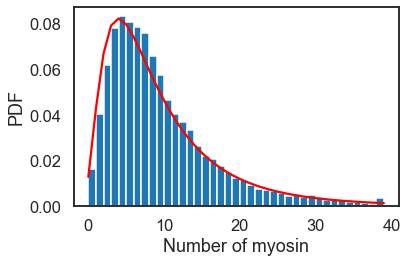

In [86]:
mu = 1   # Thickness of actin
sigma = 1
myoCap = 1000   # Cap the number of myosin per site
actinBias = .5
myosinBias = .3
numMyosin = 10000
numSim = 10

allRes = np.zeros((numSim, numGrid))
for ii in range(numSim):
    res = runSimulation(numMyosin, mu, sigma, myoCap, actinBias, myosinBias)
    allRes[ii, :] = res
    
allData = np.reshape(allRes, (numSim*numGrid))
(s, loc, scale) = st.lognorm.fit(allData, loc = 0)
xfit = np.arange(40)
plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
sns.set_style("white")
sns.set_context("talk")
plt.hist(np.reshape(allRes, (numSim*numGrid, 1)), bins = np.arange(40), density = True, stacked = True)
plt.xlabel("Number of myosin")
plt.ylabel("PDF")
plt.tight_layout()
plt.savefig("myosinBinding_histogram_acBias_0.5_myoBias_0.3_mu_1_sigma_1.png", dpi = 300)

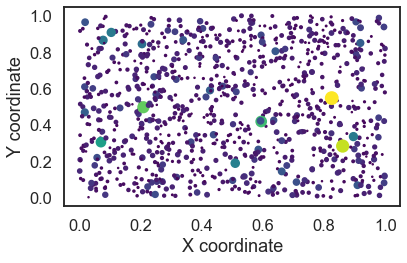

In [87]:
sns.set_style("white")
sns.set_context("talk")
plt.scatter(coordinates[:,0], coordinates[:,1], s = res, c = res, cmap = "viridis")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.tight_layout()
plt.savefig("myosinBinding_map_acBias_0.5_myoBias_0.3.png", dpi = 300)

3953.4968549675964
6868.177043360022
11161.516435368332


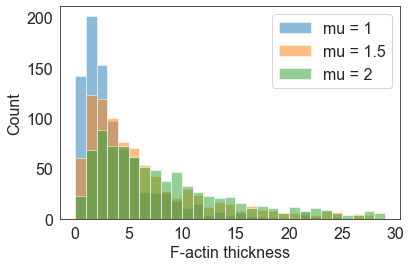

In [60]:
sigma = 1
for mu in [1,1.5,2]:
    thickness = np.random.lognormal(mu, sigma, 900)
    print(sum(thickness))
    plt.hist(thickness, alpha = 0.5, bins = np.arange(30), label = 'mu = '+str(mu))
plt.xlabel("F-actin thickness")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("Actin_thickness_muComp.png", dpi = 300)

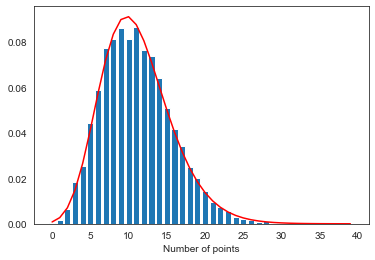

In [11]:
sns.set_style("white")
plt.figure()
allData = np.reshape(allRes, (numGrid*numGrid*10))
(s, loc, scale) = st.lognorm.fit(allData, loc = 0)
xfit = np.arange(40)
plt.plot(xfit, st.lognorm.pdf(xfit, s, loc, scale), c = 'red')
plt.bar(xfit, avgHist[0:40]/sum(avgHist))
plt.xlabel("Number of myosin")
plt.ylabel("PDF")
plt.savefig("myosinBinding_histogram_acBias_1_myoBias_0_lam_6.png", dpi = 300)

In [ ]:
sns.set_style("white")
plt.figure()
sns.histplot(np.reshape(MyosinPoints, (numGrid*numGrid)), binwidth = 1)
plt.xlabel("Number of points")
#plt.savefig("myosinBinding_histogram_acBias_1_myoBias_0.5.png", dpi = 300)
#plt.hist(np.reshape(MyosinPoints, (numGrid*numGrid)), bins = np.arange(np.max(MyosinPoints)))

## 2D case
In construction...

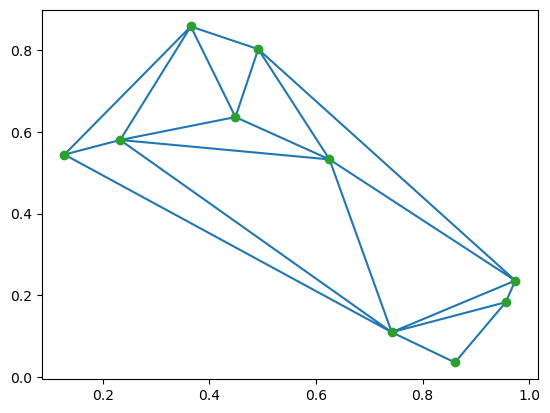

In [5]:
# Define initial network structure
numGrid = 10
coordinates = np.zeros((numGrid, 2))
for ii in range(numGrid):
    coordinates[ii, 0] = random.random()
    coordinates[ii, 1] = random.random()

tri = Delaunay(coordinates)
plt.triplot(coordinates[:,0], coordinates[:,1], tri.simplices)
plt.plot(coordinates[:,0], coordinates[:,1], 'o')
plt.show()

In [11]:
tri.simplices

array([[6, 5, 2],
       [3, 6, 7],
       [6, 3, 5],
       [3, 0, 5],
       [0, 7, 4],
       [0, 3, 7],
       [8, 9, 1],
       [0, 9, 5],
       [5, 9, 2],
       [9, 8, 2],
       [9, 0, 4]], dtype=int32)

In [10]:
coordinates.tolist()[0]

[0.2327347347226143, 0.5804723624457677]

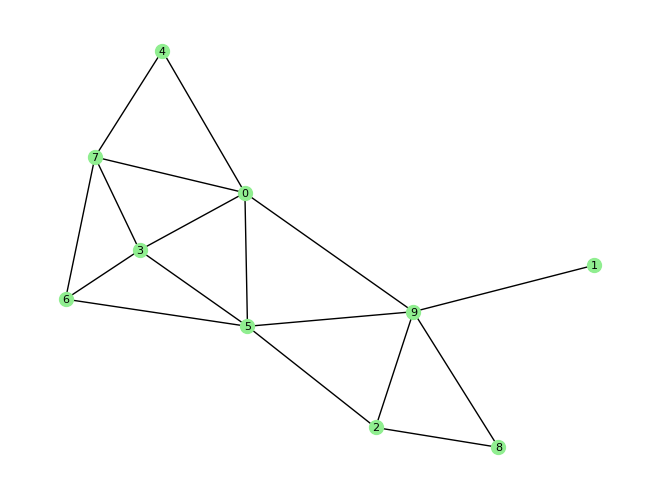

In [12]:
G = nx.Graph()
#G.add_nodes_from(coordinates.tolist())
for path in tri.simplices:
    nx.add_path(G, path)
    
nx.draw(G, with_labels=True, node_size=100, node_color='lightgreen', font_size=8)

In [5]:
tri.points[0]==coordinates[0,:]

array([ True,  True])

In [6]:
# Extract neighbors
vertex_id = 1
index_pointers, indices = tri.vertex_neighbor_vertices
result_id = indices[index_pointers[vertex_id]:index_pointers[vertex_id+1]]
result_id

array([983, 684, 436,  70, 398, 851], dtype=int32)

In [61]:
weights = np.array([.1, .2, .1, .4, .2, .3])
myoCap = 6
weights[np.array([3,5,2,7,4,2])>=myoCap] = weights[np.array([3,5,2,7,4,2])>=myoCap]*np.exp(-())
weights

array([0.1, 0.2, 0.1, 2. , 0.2, 0.3])